# Training of model with just municipalities

In [15]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
import tqdm
from math import sqrt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

df = pd.read_csv('Boliga - Final for training.csv')
df = df.drop(columns = ['Kommune', 'lotSize', 'Relativ Ledighed', 'Total_reported',
                        'Socioeconomic_index', 'expenses_per_school_student',
                       'expenses_sport_and_other_cultural_activities', 'forest_distance',
                       'coast_distance', 'isForeclosure', 'Ejerudgift'])

df_sample = df.sample(1000)
pd.options.display.max_columns = None

### Create dummies, and split X and Y

In [17]:
df_dum = pd.get_dummies(df_sample, drop_first = True, columns = ['Type'])
X = df_dum.drop(columns = ['price'])
y = df_dum['price']

### Split into test, dev, val and train data

In [82]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.5, random_state = 1)

### Linear Regression Model

First, we train (fit) a linear regression on the development (in this case the **training**) data, as it does not need validation (no hyperparameter needs to be optimized)

In [87]:
#Create pipeline (pipe_lr which will be used later, to compare Lasso and LR)
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=True, degree = 2), 
                        StandardScaler(with_mean = 0, with_std = True),
                        LinearRegression())

#Fit pipline to dev-data
pipe_lr.fit(X_dev, y_dev)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=0, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### OLS (linear regression) estimations table

Find a way to get the OLS estimates out here, in a table

## Train Lasso Regression (K-fold CV)

Now we want to examine whether the a Lasso regression is more appropriate, and seeks to optimize the hyperparameter.
We will train for an optimized hyperparameter on the validation set, to avoid data leakage and use k-fold crossvalidation to make sure that we have not split our dataset in a lucky or unlucky place. 

In [90]:
from sklearn.model_selection import KFold

#Split data into 5 folds
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

#Create Lambda values
lambdas = np.logspace(-4, 4, 12)
# outer loop: lambdas
mseCV = []

for lambda_ in tqdm.tqdm(lambdas):    
    # inner loop: folds
    mseCV_ = []

    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))

        
    # store result    
    mseCV.append(mseCV_) 
    
# convert to DataFrame
lambda_mseCV = pd.DataFrame(mseCV, index=lambdas)



  0%|          | 0/33 [00:00<?, ?it/s]

  3%|▎         | 1/33 [00:01<00:45,  1.41s/it]

  6%|▌         | 2/33 [00:02<00:43,  1.41s/it]

  9%|▉         | 3/33 [00:04<00:42,  1.41s/it]

 12%|█▏        | 4/33 [00:05<00:41,  1.44s/it]

 15%|█▌        | 5/33 [00:07<00:42,  1.51s/it]

 18%|█▊        | 6/33 [00:08<00:39,  1.48s/it]

 21%|██        | 7/33 [00:10<00:37,  1.44s/it]

 24%|██▍       | 8/33 [00:11<00:35,  1.41s/it]

 27%|██▋       | 9/33 [00:12<00:33,  1.39s/it]

 30%|███       | 10/33 [00:14<00:31,  1.37s/it]

 33%|███▎      | 11/33 [00:15<00:29,  1.36s/it]

 36%|███▋      | 12/33 [00:16<00:28,  1.37s/it]

 39%|███▉      | 13/33 [00:18<00:27,  1.36s/it]

 42%|████▏     | 14/33 [00:19<00:25,  1.36s/it]

 45%|████▌     | 15/33 [00:20<00:24,  1.35s/it]

 48%|████▊     | 16/33 [00:22<00:22,  1.34s/it]

 52%|█████▏    | 17/33 [00:23<00:21,  1.34s/it]

 55%|█████▍    | 18/33 [00:24<00:19,  1.33s/it]

 58%|█████▊    | 19/33 [00:26<00:18,  1.33s/it]

 61%|██████    | 20/33 [00:27<00:17,

Optimal lambda: 10000.0
Validation MSE: 2556314011187.934


### MSE of the K-fold Crossvalidation

Lambda as index

In [99]:
lambda_mseCV

,0,1,2,3,4
0.000100,6.305322e+16,3.763836e+14,9.762371e+15,1.128882e+15,4.739192e+16
0.000534,6.304047e+16,3.762878e+14,9.761759e+15,1.129169e+15,4.737166e+16
0.002848,6.297241e+16,3.757753e+14,9.758497e+15,1.130701e+15,4.726352e+16
0.015199,6.261062e+16,3.730613e+14,9.741004e+15,1.138946e+15,4.668688e+16
0.081113,6.068111e+16,3.589908e+14,9.647336e+15,1.183225e+15,4.363376e+16
0.432876,5.045438e+16,2.956660e+14,9.154442e+15,1.428895e+15,2.099799e+16
2.310130,9.312129e+15,1.864243e+14,7.336134e+15,7.741643e+15,3.248055e+14
12.328467,3.189950e+13,2.456282e+13,2.033306e+14,4.923063e+13,2.599362e+17
65.793322,3.758923e+13,5.420974e+13,4.982078e+14,4.740376e+12,5.659232e+13
351.119173,2.897875e+13,4.298317e+13,1.508062e+14,4.251068e+12,2.020214e+13


###  Mean MSE of K-fold CV

In [103]:
# Calculates the mean of the folds
mse_mean = lambda_mseCV.mean(axis = 1)

0.000100        2.434256e+16
0.000534        2.433587e+16
0.002848        2.430018e+16
0.015199        2.411010e+16
0.081113        2.310088e+16
0.432876        1.646628e+16
2.310130        4.980227e+15
12.328467       5.204905e+16
65.793322       1.302679e+14
351.119173      4.944426e+13
1873.817423     3.669625e+13
10000.000000    2.019806e+14
dtype: float64

### Plot Average MSE over Lambda

[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'Lambda')]

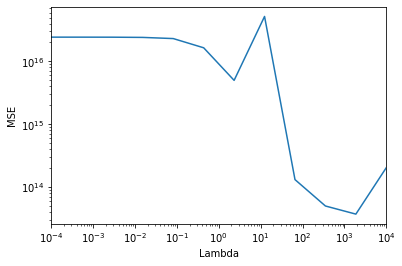

In [105]:
#Plot mean square errors
COL = ['Average MSE']
mse_mean.columns = COL

#Both axis are logarythmical 
ax = mse_mean.plot(logx = True, logy = True)
ax.set(xlabel = 'Lambda', ylabel = 'MSE')


### Finding the optimal hyperparameter

Where was the mean mse smallest?

In [107]:
mse_mean.nsmallest(1)

1873.817423    3.669625e+13
dtype: float64

# Comparison of Lasso and Linear Regression

Is done after the optimized hyperparameters is found (after training on validation data)
This comparison is done on the **test data!** and is thus the final step in training and selecting our model


In [98]:
# Optimal lambda is inserted into the Lasso-model
optimal_lambda = lambda_mseCV.mean(axis=1).nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=1))
pipe_lassoCV.fit(X_dev,y_dev)

# compare performance by mse
models = {'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score_mse = mse(model.predict(X_test),y_test)
    score_mae = mae(model.predict(X_test),y_test)
    score_rmse = sqrt(mse(model.predict(X_test),y_test))
    
    print("MSE: " + name, round(score_mse, 2))
    print("RMSE: " + name, round(score_rmse, 2))
    print("MAE: " + name, round(score_mae, 2))

Lasso CV 3707008864522.99
LinReg 2683899699688577.5


## Subconclusion

The model is too complex and very unable to predict out-of-sample data. 
Though the Lasso is a great imporvement to the simple linear regression, it still produces error in the realm of trillions. 
Consider making a more simple model instead

## Error Table

We calculate the Mean Absolute Error, Mean Squared Error and Root Mean Squard Errors of the differnet models: OLS (Linear Regression), Lasso, Ridge.

## Correlation plot

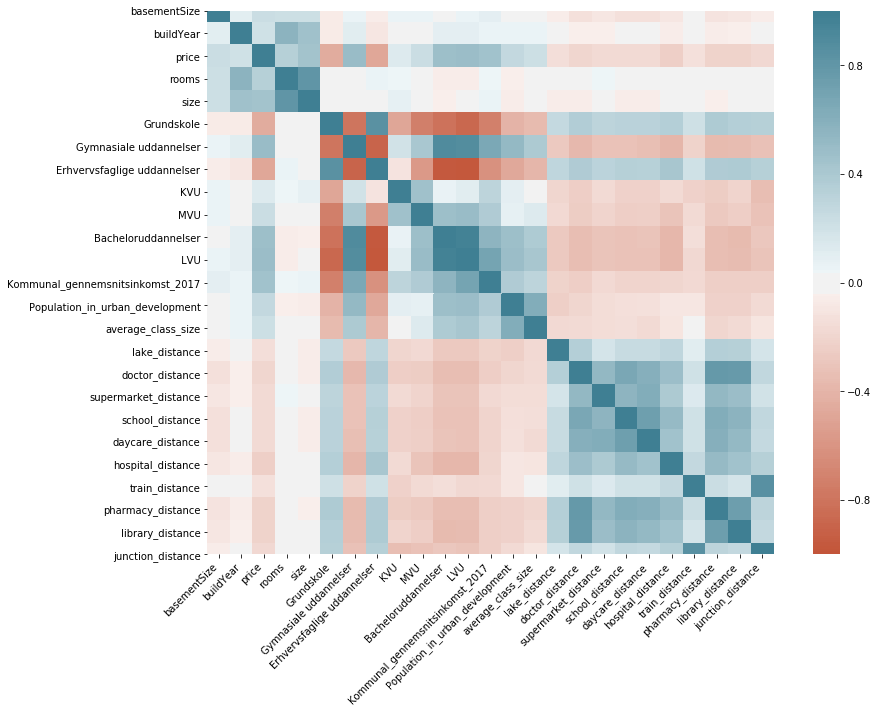

In [14]:
corr = df.corr()
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);